In [168]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

import torch.nn.functional as F

from sklearn.manifold import TSNE

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

## Loading and Formatting Train/Test/Validation Data

In [169]:
base_dir = '../Data_Generation/Data_files/labeled_points/'
base_fp = base_dir + '../points/sl2_Z_3s.csv'
test_fp = base_dir + 'sl2_Z_3s_test.csv'
train_fp = base_dir + 'sl2_Z_3s_train.csv'

In [201]:
# Load data
df = pd.read_csv(base_fp)
train_df = pd.read_csv(train_fp)
test_df = pd.read_csv(test_fp)

xs_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_xtra_small.csv')
s_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_small.csv')
m_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_medium.csv')
l_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_large.csv')
xl_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_xtra_large.csv')

In [202]:
# Converting Sized DataFrames to matrices
xs_data = torch.tensor(xs_data.values, dtype=torch.float64)
xs_mats = xs_data[:, :4].reshape(-1, 2, 2)
xs_labels = xs_data[:, 4]

s_data = torch.tensor(s_data.values, dtype=torch.float64)
s_mats = s_data[:, :4].reshape(-1, 2, 2)
s_labels = s_data[:, 4]

m_data = torch.tensor(m_data.values, dtype=torch.float64)
m_mats = m_data[:, :4].reshape(-1, 2, 2)
m_labels = m_data[:, 4]

l_data = torch.tensor(l_data.values, dtype=torch.float64)
l_mats = l_data[:, :4].reshape(-1, 2, 2)
l_labels = l_data[:, 4]

xl_data = torch.tensor(xl_data.values, dtype=torch.float64)
xl_mats = xl_data[:, :4].reshape(-1, 2, 2)
xl_labels = xl_data[:, 4]

# All matrices with tabular Q predictions
matrices_all = torch.tensor(df.values, dtype=torch.float64).reshape(100000, 2, 2)

# Training matrices and labels
train_data = torch.tensor(train_df.values, dtype=torch.float64)
labels_train = train_data[:,-1]
matrices_train = train_data[:,0:-2].reshape(train_data.shape[0], 2, 2)

# Testing matrices and labels
test_data = torch.tensor(test_df.values, dtype=torch.float64)
labels_test = test_data[:,-1]
matrices_test = test_data[:,0:-2].reshape(test_data.shape[0], 2, 2)
basis_vec = torch.tensor([[1, 0]], dtype=torch.float64)
vecs_all = matrices_all.matmul(basis_vec.T)
vecs_train = matrices_train.matmul(basis_vec.T)
vecs_test = matrices_test.matmul(basis_vec.T)
x_train = vecs_train[:, 0]
x_test = vecs_test[:, 0]
y_train = vecs_train[:, 1]
y_test = vecs_test[:, 1]

## Model Definition

In [172]:
MAX_REWARD = 100
STEP_PENALTY = -1

def normalize_mat(mat: torch.Tensor) -> torch.Tensor:
    max_entry, _ = mat.max(dim=-1)
    min_entry, _ = mat.min(dim=-1)
    max_entry = max_entry.unsqueeze(-1)
    min_entry = min_entry.unsqueeze(-1)
    # print(max_entry.shape)
    # print(min_entry.shape)
    # print((mat - min_entry) / (max_entry - min_entry))
    return (mat - min_entry) / (max_entry - min_entry)

def get_reward_log(state: torch.Tensor) -> tuple[float, bool]:
    if state.equal(torch.eye(2)):
        return (MAX_REWARD, True)
    l2_log = -torch.log((state**2).sum()).item() + 90
    return (l2_log, False)

def get_reward(state: torch.Tensor) -> tuple[int, bool]:
    if state.equal(torch.eye(2, dtype=torch.float64)):
        return (MAX_REWARD, True)
    return (STEP_PENALTY, False)

In [109]:
# https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
def kaiming_initializer(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        layer.bias.data.fill_(0.01)

### Network Architecture
(Linear $\to$ BatchNorm $\to$ ReLU) $\times$ 3 $\to$ Linear

In [153]:
class DeepQModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepQModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128, dtype=torch.float64),
            nn.BatchNorm1d(128, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=torch.float64),
            nn.BatchNorm1d(64, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(64, 16, dtype=torch.float64),
            nn.BatchNorm1d(16, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(16, output_size, dtype=torch.float64),
        )

        #self.stack.apply(kaiming_initializer)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_norm = normalize_mat(x)
        return self.stack(x_norm)

In [189]:
MATRIX_SIZE = 4     # i.e. 2x2
NUM_GENERATORS = 4  # Number of generators in group (including inverses)

class DeepQAgent:
    def __init__(self, learning_rate: float, epsilon: float, epsilon_decay: float, 
                 min_epsilon: float, discount_factor: float, batch_size: int, memory_capacity: int):
        # Initialize main an target models and set weights to be equivalent
        self.mainModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel.eval()
        
        # TODO: check if this works
        self.copy_main_to_target()

        # Initialize Hyperparameters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.replay_cnt = 0

        # Optimization initialization
        self.optimizer = optim.Adam(self.mainModel.parameters(), lr=self.learning_rate)

        # Experience Replay Buffers and parameters
        self.memory = deque()
       
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.mainModel.forward(x.reshape(1, 4))

    def epsilon_greedy_search(self, state):
        if torch.rand(1) <= self.epsilon:
            return int(torch.randint(0, NUM_GENERATORS, (1,)).item())
        
        # Utilizes evauation mode for batch normalization when evaluating a single matrix
        self.mainModel.eval()

        pred_idx = int(self.mainModel.forward(state).argmax().item())

        # Re-enables train mode for batch normalization to track statistics across batches
        self.mainModel.train()

        return pred_idx

    def copy_main_to_target(self):
        self.targetModel.load_state_dict(self.mainModel.state_dict())

    # Citing Algorithm 1 https://arxiv.org/pdf/1312.5602.pdf
    def replay(self):
        # Ensure there is enough memory for a full batch
        if len(self.memory) <  self.batch_size:
            print('Skipping replay, not enough memory')
            return
        self.replay_cnt += 1

        # Random sample a batch_size's worth of memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Vectorizing data
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.stack(states)
        next_states = torch.stack(next_states)
        actions = torch.tensor(actions, dtype=torch.int64) # Stores matrices multiplied by, NOT index
        rewards = torch.tensor(rewards, dtype=torch.float64)
        dones = torch.tensor(dones, dtype=torch.float64)
        
        # Bellman Equation: (Reward + discount_factor * state_prediction)
        next_q_predictions, _ = self.targetModel.forward(next_states.reshape(-1, 4)).max(dim=1)
        q_values = self.mainModel.forward(states.reshape(-1, 4))[torch.arange(0, states.shape[0]), actions]
        bellmans = rewards + (1 - dones) * self.discount_factor * next_q_predictions

        # Calculate loss and perform optimization step
        loss = F.mse_loss(q_values, bellmans)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform Epsilon decay for each training step
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
    def remember(self, state, action, reward, next_state, done: bool):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.popleft()



In [210]:
class DeepQAgentTrainer: 
    def __init__(self, agent: DeepQAgent, actions: list[torch.Tensor], train_matrices: torch.Tensor, batch_size: int):
        self.agent = agent
        self.actions = actions
        self.train_matrices = train_matrices
        self.batch_size = batch_size
        self.total_episodes = 0
    
    def play(self, episodes: int, sync_target_every: int, max_game_len: int, print_every: int = 10, replay_every: int = 1):
        '''
        episodes - The number of episodes or 'games' played by the agent to train
        replay_periodicity - The number of episodes after which weights will be updated
        '''
        sample_idxs = torch.randint(0, self.train_matrices.shape[0], (episodes, ))
        for episode in torch.arange(0, episodes):
            if episode % print_every == 0:
                print(f"Episode {episode+1}/{episodes}:")

            mat = self.train_matrices[sample_idxs[episode]]

            steps = 0
            done = False
            while steps < max_game_len and not done:
                pred_action_idx = self.agent.epsilon_greedy_search(mat.reshape(1, 4)) # self.agent.predict(mat).argmax(dim=0)
                action = self.actions[pred_action_idx]
                next_mat = torch.matmul(mat, action)
                reward, done = get_reward(next_mat)
                self.agent.remember(mat, pred_action_idx, reward, next_mat, done)

                # Update necessary vars for next iteration
                mat = next_mat
                steps += 1
            
            # Copy weights if necessary
            if episode % sync_target_every == 0 and episode != 0:
                self.agent.copy_main_to_target()
              
            if episode % replay_every == 0:
                self.agent.replay()
        
        return self.agent.memory 

    def play_dbg(self, start: torch.Tensor, max_game_len: int):
        '''
        episodes - The number of episodes or 'games' played by the agent to train
        replay_periodicity - The number of episodes after which weights will be updated
        '''
        walk = []
        rewards = []
        acts = []
        mat = start

        steps = 0
        done = False
        while steps < max_game_len and not done:
            pred = self.agent.epsilon_greedy_search(mat.flatten())
            action = self.actions[pred]
            next_mat = torch.matmul(mat, action)
            reward, done = get_reward(mat)
            self.agent.remember(mat, pred, reward, next_mat, done)

            # Update necessary vars for next iteration
            walk.append(mat)
            rewards.append(reward)
            acts.append(pred)
            mat = next_mat
            steps += 1
        self.agent.replay()
        
        return (walk, rewards, acts)


In [225]:
dqa = DeepQAgent(learning_rate=0.001, epsilon=1.0, epsilon_decay=0.999, min_epsilon=.01, discount_factor=.99, batch_size=100, memory_capacity=10_000)

In [226]:
U = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
T = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)
U_INV = U.inverse()
T_INV = T.inverse()

generators = [U, T, U_INV, T_INV]

agent_trainer = DeepQAgentTrainer(dqa, generators, l_mats, 100)

In [227]:
mem = agent_trainer.play(episodes=4000,
                         sync_target_every=10,
                         max_game_len=20,
                         print_every=250,
                         replay_every=1)

Episode 1/4000:
Skipping replay, not enough memory
Skipping replay, not enough memory
Skipping replay, not enough memory
Skipping replay, not enough memory
Episode 251/4000:
Episode 501/4000:
Episode 751/4000:
Episode 1001/4000:
Episode 1251/4000:
Episode 1501/4000:
Episode 1751/4000:
Episode 2001/4000:
Episode 2251/4000:
Episode 2501/4000:
Episode 2751/4000:
Episode 3001/4000:
Episode 3251/4000:
Episode 3501/4000:
Episode 3751/4000:


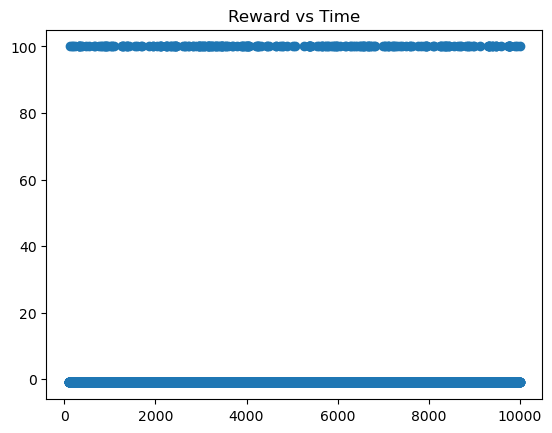

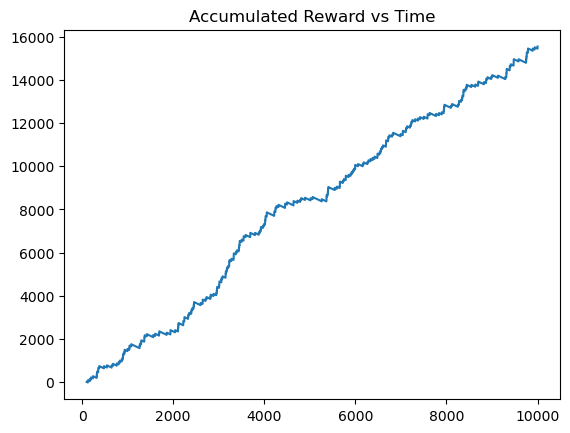

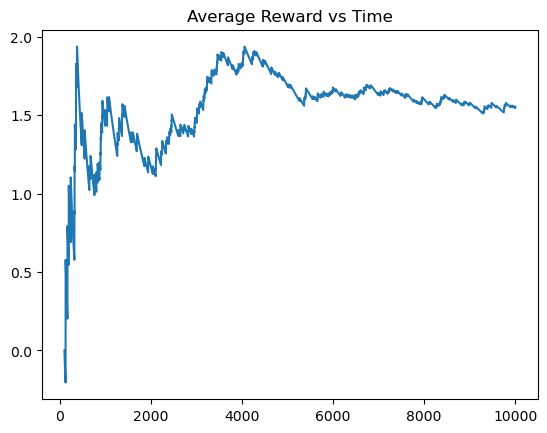

In [228]:
rs = []
cumulative_rs = []
avg_rs = []
acc = 0
for idx, m in enumerate(mem):
    acc += m[2]
    cumulative_rs.append(acc)
    avg_rs.append(acc/(idx+1))
    rs.append(m[2])

plt.scatter(torch.arange(100, len(rs)), rs[100:])
plt.title('Reward vs Time')
plt.show()

plt.plot(torch.arange(100, len(cumulative_rs)), cumulative_rs[100:])
plt.title('Accumulated Reward vs Time')
plt.show()

plt.plot(torch.arange(100, len(avg_rs)), avg_rs[100:])
plt.title('Average Reward vs Time')
plt.show()

In [229]:
dqa.mainModel.eval()

print(dqa.mainModel.forward(U.unsqueeze(0).flatten(start_dim=1)))
print(dqa.mainModel.forward(T.reshape(1,4)))
print(dqa.mainModel.forward((U@T@U@T@U@U).reshape(1,4)))

dqa.mainModel.train()

tensor([[62.9050, 67.2835, 97.8579, 69.7263]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)
tensor([[ 63.9925,  65.8264,  64.5983, 100.9870]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)
tensor([[48.1866, 53.4722, 68.7390, 48.6062]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)


DeepQModel(
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [230]:
dqa.mainModel.eval()

q_vals, pred_action_idx = dqa.mainModel.forward(matrices_train.reshape(69999, 4)).max(dim=1, keepdim=True)
xs_qs, xs_pred_acts = dqa.mainModel.forward(xs_mats.reshape(-1, 4)).max(dim=1, keepdim=True)
m_qs, m_pred_acts = dqa.mainModel.forward(m_mats.reshape(-1, 4)).max(dim=1, keepdim=True)
l_qs, l_pred_acts = dqa.mainModel.forward(l_mats.reshape(-1,4)).max(dim=1, keepdim=True)

dqa.mainModel.train()

DeepQModel(
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=4, bias=True)
  )
)

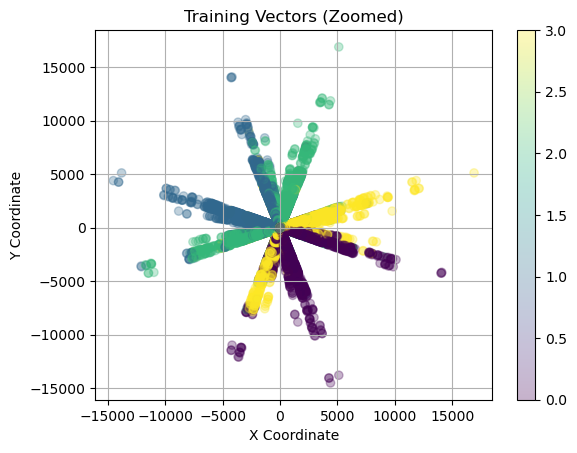

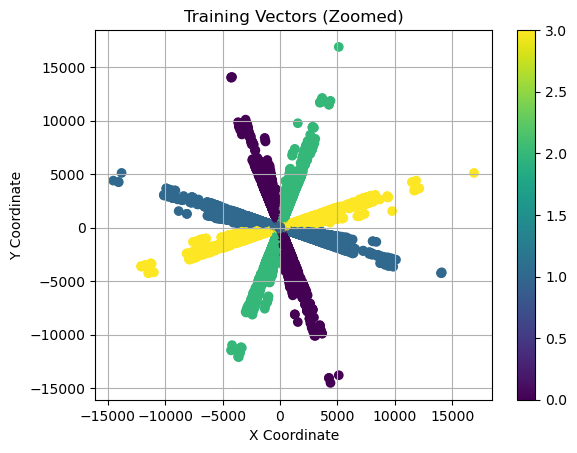

In [231]:
b = torch.tensor([[1], [1]], dtype=torch.float64)
xs_vecs = b.T.matmul(xs_mats).flatten(start_dim=1)
m_vecs = b.T.matmul(m_mats).flatten(start_dim=1)
l_vecs = b.T.matmul(l_mats).flatten(start_dim=1)

plt.scatter(l_vecs[:, 0], l_vecs[:, 1], c=l_pred_acts, alpha=.3)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.colorbar()
plt.show()

plt.scatter(l_vecs[:, 0], l_vecs[:, 1], c=l_labels)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.colorbar()
plt.show()


# plt.scatter(x_train[train_mask], y_train[train_mask], c=pred_action_idx[train_mask.flatten()])
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Training Vectors (Zoomed)')
# plt.grid(True)
# plt.colorbar()
# plt.show()

# plt.scatter(x_train, y_train, c=pred_action_idx, alpha=.5)
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Test Vectors (All)')
# plt.colorbar()
# plt.grid(True)
# plt.show()

In [232]:
print(f"Close (extra small) Accuracy: {(xs_pred_acts.flatten() == xs_labels).sum() / xs_labels.shape[0]}")
print(f"Middle (medium) Accuracy: {(m_pred_acts.flatten() == m_labels).sum() / m_labels.shape[0]}")
print(f"Far (large) Accuracy: {(l_pred_acts.flatten() == l_labels).sum() / l_labels.shape[0]}")

Close (extra small) Accuracy: 0.5558823347091675
Middle (medium) Accuracy: 0.436824768781662
Far (large) Accuracy: 0.4208972156047821


In [254]:
dqa.mainModel.eval()

print(dqa.predict(U).argmax(dim=1))     # Expected output is 2 for U inverse
print(dqa.predict(T).argmax(dim=1))     # Expected output is 3 for T inverse
print(dqa.predict(U_INV).argmax(dim=1)) # Expected output is 0 for U
print(dqa.predict(T_INV).argmax(dim=1)) # Expected output is 1 for T

dqa.mainModel.train()

tensor([2])
tensor([3])
tensor([0])
tensor([1])


DeepQModel(
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=4, bias=True)
  )
)